# Лаб 3. машины опорных векторов

Набор данных - moabb (описание подключения https://gitlab.com/impulse-neiry/posts/-/blob/master/post01_simple_p300/post01ru_simple_p300.ipynb)

MOABB (Mother of All BCI Benchmarks) — это фреймворк и набор данных, разработанные для стандартизации и упрощения процесса оценки методов анализа данных в области интерфейсов "мозг-компьютер" (Brain-Computer Interface, BCI). MOABB позволяет исследователям сравнивать алгоритмы и модели машинного обучения на множестве разных BCI задач с использованием единых процедур и методов.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!pip install moabb

In [1]:
import moabb.datasets
sampling_rate = 512

m_dataset = moabb.datasets.bi2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)
m_dataset.download()
m_data = m_dataset.get_data()

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|███████████████████████████████████████| 265M/265M [00:00<00:00, 84.8GB/s]
SHA256 hash of downloaded file: 8c0c9cb3e3345247430d5945e91c645bffa4074f79a196ac911aefde67a0acc1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1

In [4]:
m_data[1]

{'3': {'0': <RawArray | 17 x 146592 (286.3 s), ~19.0 MB, data loaded>,
  '1': <RawArray | 17 x 97504 (190.4 s), ~12.7 MB, data loaded>,
  '2': <RawArray | 17 x 133344 (260.4 s), ~17.3 MB, data loaded>,
  '3': <RawArray | 17 x 128640 (251.2 s), ~16.7 MB, data loaded>},
 '7': {'0': <RawArray | 17 x 129824 (253.6 s), ~16.9 MB, data loaded>,
  '1': <RawArray | 17 x 94560 (184.7 s), ~12.3 MB, data loaded>,
  '2': <RawArray | 17 x 132064 (257.9 s), ~17.2 MB, data loaded>,
  '3': <RawArray | 17 x 97152 (189.7 s), ~12.6 MB, data loaded>},
 '5': {'0': <RawArray | 17 x 132896 (259.6 s), ~17.3 MB, data loaded>,
  '1': <RawArray | 17 x 102528 (200.2 s), ~13.3 MB, data loaded>,
  '2': <RawArray | 17 x 130528 (254.9 s), ~17.0 MB, data loaded>,
  '3': <RawArray | 17 x 127968 (249.9 s), ~16.6 MB, data loaded>},
 '2': {'0': <RawArray | 17 x 131776 (257.4 s), ~17.1 MB, data loaded>,
  '1': <RawArray | 17 x 101184 (197.6 s), ~13.2 MB, data loaded>,
  '2': <RawArray | 17 x 133024 (259.8 s), ~17.3 MB, data

In [5]:
print(m_data[1]['1']['0'])
channels = m_data[1]['1']['0'].ch_names[:-1]
channels

<RawArray | 17 x 132896 (259.6 s), ~17.3 MB, data loaded>


['Fp1',
 'Fp2',
 'F5',
 'AFz',
 'F6',
 'T7',
 'Cz',
 'T8',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'O1',
 'Oz',
 'O2']

In [6]:
raw_dataset = []

for _, sessions in sorted(m_data.items()):
    eegs, markers = [], []
    for item, run in sorted(sessions[sorted(sessions.keys())[0]].items()):
        data = run.get_data()
        eegs.append(data[:-1])
        markers.append(data[-1])
    raw_dataset.append((eegs, markers))

In [7]:
from scipy import signal
from sklearn.base import BaseEstimator, TransformerMixin

class Transformer(BaseEstimator, TransformerMixin):
    '''
    Базовый класс для преобразователей, обеспечивающий фиктивную реализацию методов.
    Он предоставляет общую структуру и гарантирует, что у всех наследников будет метод fit, который можно переопределять.
    Это позволяет унифицировать интерфейс преобразователей.
    '''
    def fit(self, x, y=None):
        return self

class ButterFilter(Transformer):
    '''
    Применяет фильтрацию к сигналам ЭЭГ с помощью полосового фильтра Баттерворта.
    Это полезно для удаления шума или нежелательных частот в сигнале, чтобы сохранить только те частоты, которые представляют интерес для анализа (например, определенные диапазоны частот ЭЭГ).
    '''
    def __init__(self, sampling_rate: int, order: int, highpass: int, lowpass: int) -> None:
        self.sampling_rate = sampling_rate
        self.order = order
        self.highpass = highpass
        self.lowpass = lowpass

        normal_cutoff = [a / (0.5 * self.sampling_rate) for a in (self.highpass, self.lowpass)]
        self.filter = signal.butter(self.order, normal_cutoff, btype='bandpass')

    def transform(self, x):
        out = np.empty_like(x)
        out[:] = [signal.filtfilt(*self.filter, item) for item in x]
        return out

class Decimator(Transformer):
    '''
    Снижает частоту дискретизации сигналов.
    Это может быть необходимо для уменьшения объема данных и ускорения последующего анализа, особенно если исходные данные имеют слишком высокую частоту дискретизации для целей обработки.
    '''
    def __init__(self, factor: int):
        '''
        factor: коэффициент понижения дискретизации, не должен быть больше 13,
        см. :py:funct:`scipy.signal.decimate` для получения дополнительной информации
        '''
        self.factor = factor

    def transform(self, x):
        '''
        Аргументы:
            x: итерируемый объект, содержащий np.ndarray
        Возвращает:
            np.ndarray объектов типа np.object формы (len(x), )
            Другими словами, выводится ndarray объектов, каждый из которых является
            результатом понижения дискретизации элементов из x.
        '''
        out = np.empty(len(x), dtype=np.object)
        out[:] = [signal.decimate(item, self.factor) for item in x]
        return out

class ChannellwiseScaler(Transformer):
    '''
    Выполняет масштабирование по каналам в соответствии с заданным масштабирующим коэффициентом (scaler).
    '''
    def __init__(self, scaler: Transformer):
        '''
        Аргументы:
        scaler: экземпляр одного из классов sklearn.preprocessing, таких как StandardScaler, MinMaxScaler или аналог.
        '''
        self.scaler = scaler

    def fit(self, x: np.ndarray, y=None):
        '''
        Аргументы:
            x: массив ЭЭГ, где каждый элемент x имеет форму (n_channels, n_ticks)
                x имеет форму (n_eegs) двумерного массива или (n_eegs, n_channels, n_ticks)
        '''
        for signals in x:
            self.scaler.partial_fit(signals.T)
        return self

    def transform(self, x):
        '''
        Масштабирует каждый канал
        Работает либо с одной записью (2-мерный ввод, (n_channels, n_samples)),
        либо с множеством записей (3-мерный ввод, (n_records, n_channels, n_samples)).
        Возвращает формат, аналогичный входным данным.
        '''
        scaled = np.empty_like(x)
        for i, signals in enumerate(x):
            # double T for scaling each channel separately
            scaled[i] = self.scaler.transform(signals.T).T
        return scaled


class MarkersTransformer(Transformer):
    '''
    Преобразует каналы маркеров в массивы индексов начала эпох и меток.
    '''
    def __init__(self, labels_mapping: dict, decimation_factor: int=1, empty_label: float=0.):
        self.labels_mapping = labels_mapping
        self.decimation_factor = decimation_factor
        self.empty_label = empty_label

    def transform(self, batch):
        res = []
        for markers in batch:
            index_label = []
            for index, label in enumerate(markers):
                if label == self.empty_label: continue
                index_label.append([
                    index // self.decimation_factor,
                    self.labels_mapping[label],
                ])
            res.append(np.array(index_label, dtype=np.int))
        return res

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sampling_rate = 512
decimation_factor = 10
final_rate = sampling_rate // decimation_factor
epoch_duration = 0.9 # seconds
labels_mapping = {33285.: 1, 33286.: 0}
captions = {0: 'empty', 1: 'target'}
np.object = object
eeg_pipe = make_pipeline(
    Decimator(decimation_factor),
    ButterFilter(sampling_rate // decimation_factor, 4, 0.5, 20),
    ChannellwiseScaler(StandardScaler()),
)
markers_pipe = MarkersTransformer(labels_mapping, decimation_factor)

In [9]:
for eegs, _ in raw_dataset:
    eeg_pipe.fit(eegs)

In [10]:
dataset = []
epoch_count = int(epoch_duration * final_rate)
np.int = int
np.float = float
np.bool = bool
for eegs, markers in raw_dataset:
    epochs = []
    labels = []
    filtered = eeg_pipe.transform(eegs)
    markups = markers_pipe.transform(markers)
    for signal_t, markup in zip(filtered, markups):
        epochs.extend([signal_t[:, start:(start + epoch_count)] for start in markup[:, 0]])
        labels.extend(markup[:, 1])
    dataset.append((np.array(epochs), np.array(labels)))

In [11]:
raw_sample = raw_dataset[0][0][0]
len(raw_dataset), len(raw_dataset[0]), len(raw_dataset[0][0]), raw_dataset[0][0][0].shape

(24, 2, 4, (16, 159232))

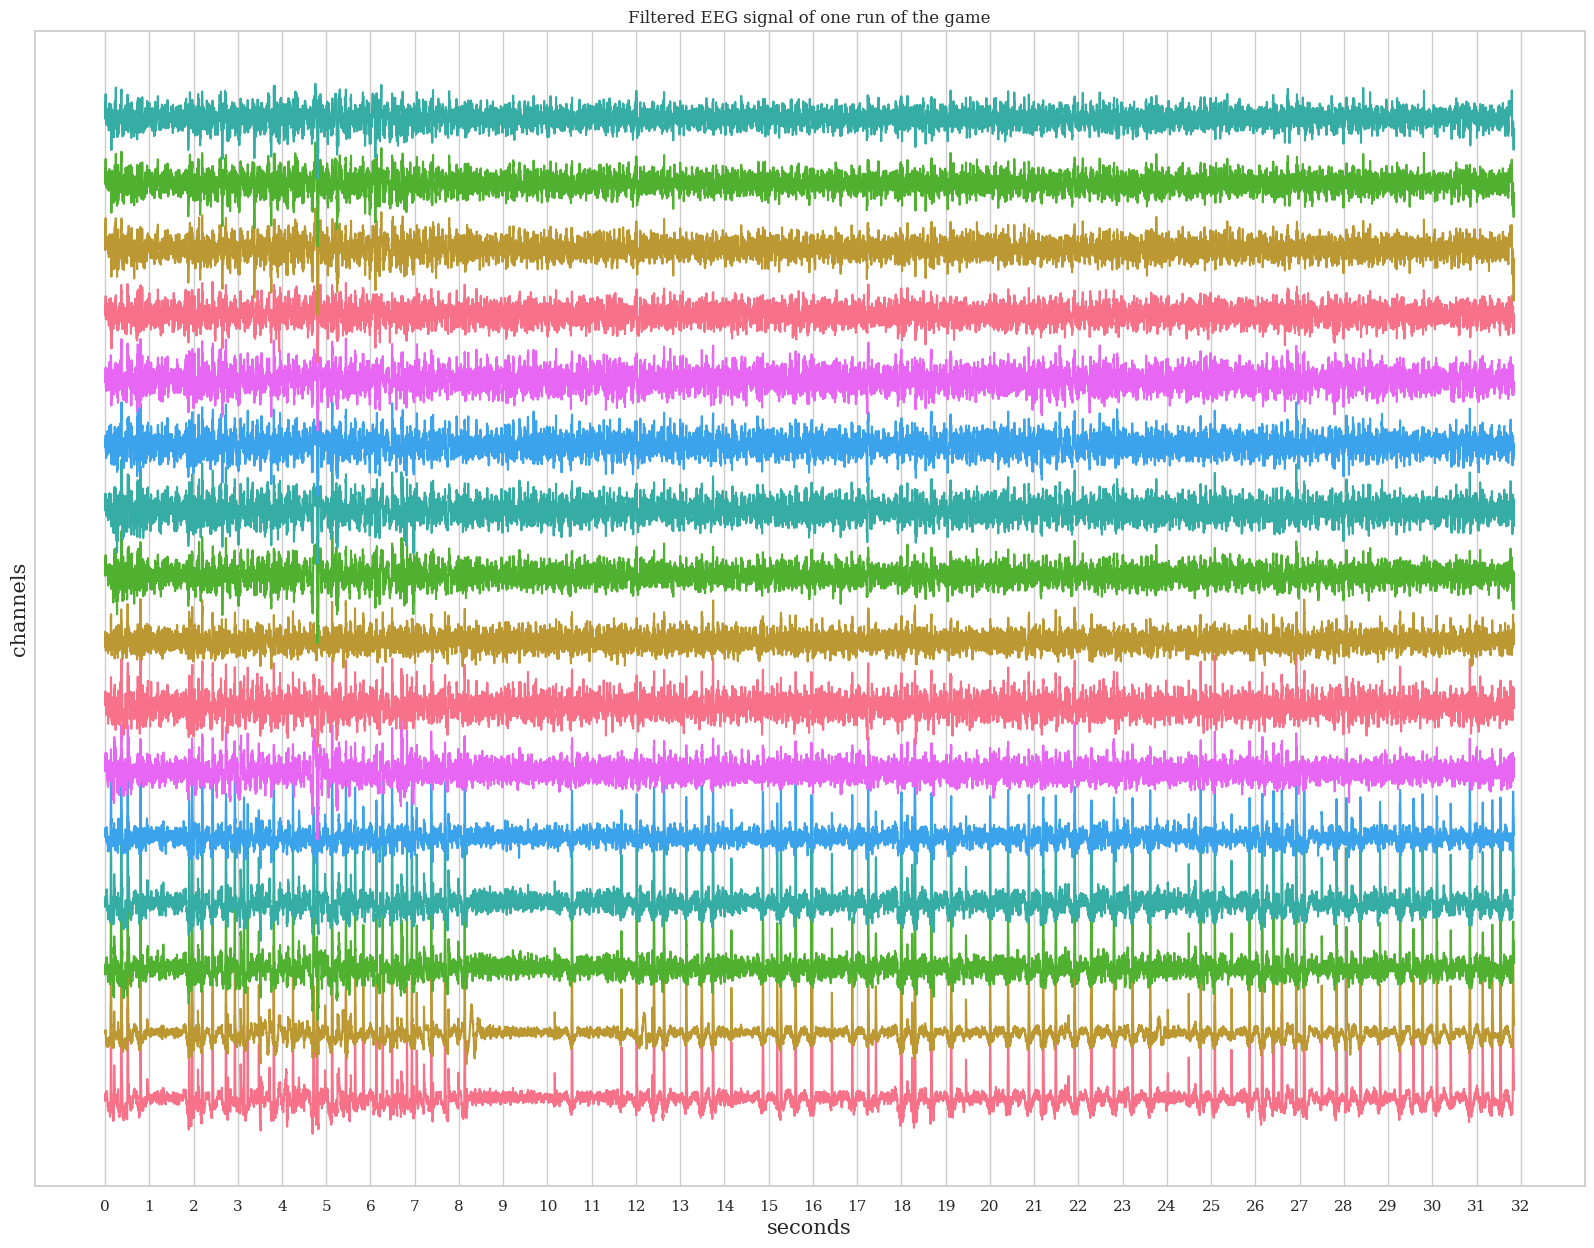

In [12]:
epoch = eeg_pipe.fit_transform([raw_sample])[0]
plt.figure(figsize=(20, 15))
plt.plot(epoch.T + np.arange(len(epoch))*5)
plt.yticks([])
plt.xticks(np.arange(0, 16000 + 1, 500), np.arange(0, 33, 1))
plt.xlabel('seconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.title('Filtered EEG signal of one run of the game')
plt.show()

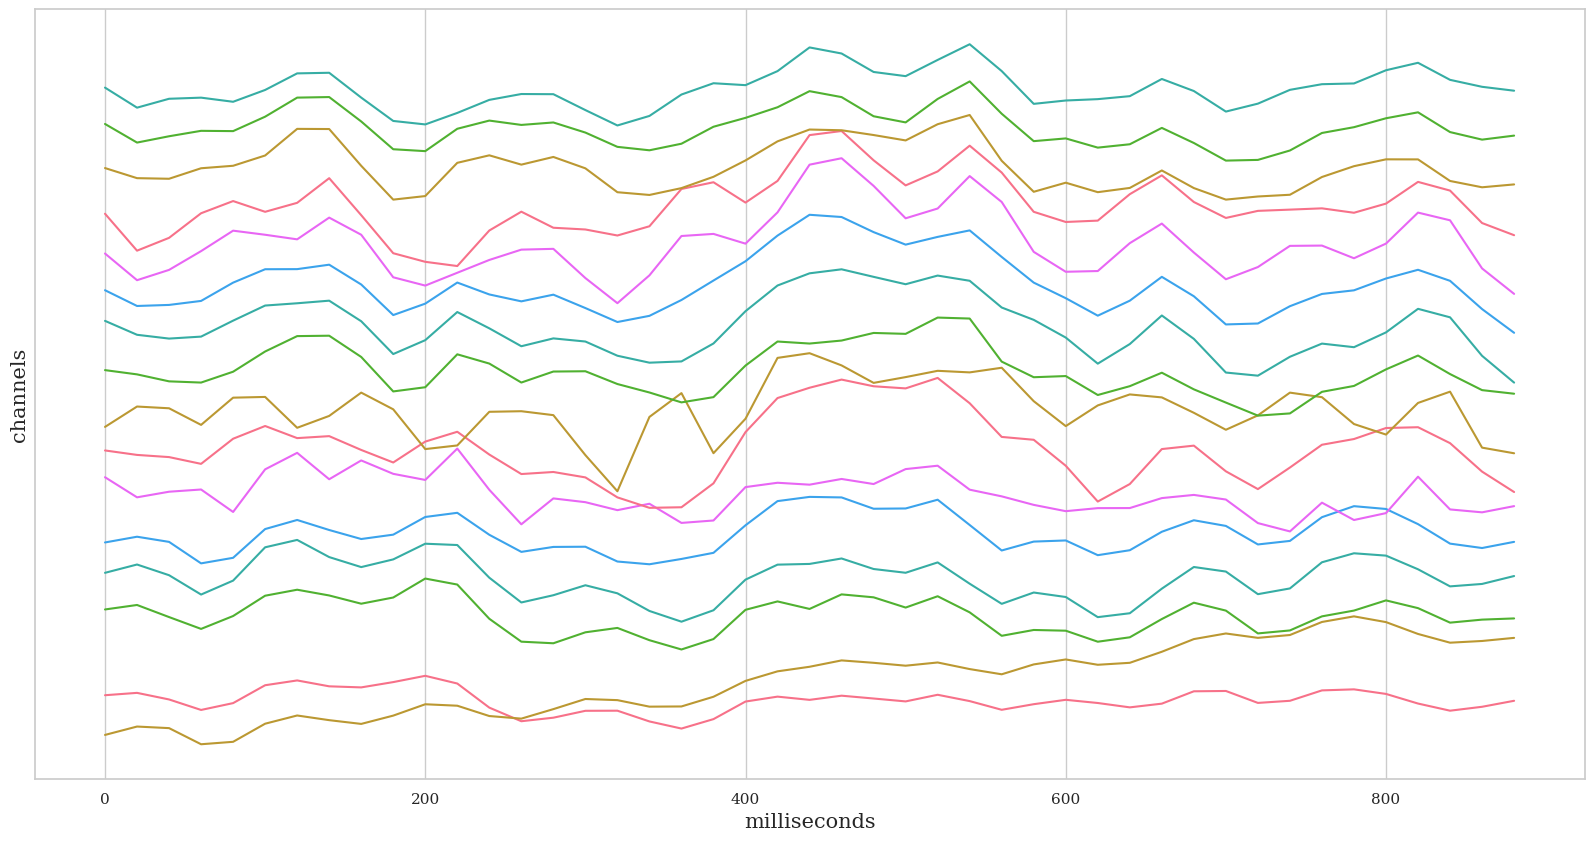

In [13]:
epoch = dataset[0][0][0]
plt.figure(figsize=(20, 10))
plt.plot(epoch.T + np.arange(len(epoch)))
plt.yticks([])
plt.xticks(np.arange(0, 50, 10), np.arange(0, 1000, 200))
plt.xlabel('milliseconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.show()

In [14]:
all_epochs = np.concatenate([epochs for epochs, _ in dataset])
all_epochs.shape, all_epochs.dtype

((34872, 16, 45), dtype('float64'))

5.0


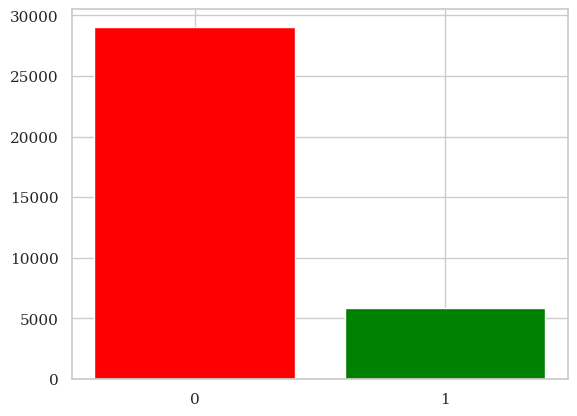

In [15]:
all_labels = np.concatenate([labels for _, labels in dataset])

uniques, counts = np.unique(all_labels, return_counts=True)

plt.bar(uniques, counts, color=['r', 'g'])
plt.xticks(uniques)

print(counts[0] / counts[1])

In [16]:
def plot_by_labels(epochs, labels):
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    for label in (0, 1):
        mean = epochs[labels == label].mean(axis=(0, 1))
        std = epochs[labels == label].std(axis=(0, 1))

        axes[0].plot(mean, label=captions[label])

        axes[1].plot(mean, label=captions[label])
        axes[1].fill_between(np.arange(mean.size), mean-std, mean+std, alpha=0.25)

    axes[0].legend(fontsize=20)
    axes[0].set_ylim(-0.16, 0.26)
    axes[1].set_ylim(-0.8, 0.85)
    for i, title in enumerate(('Means', 'Means with Stds')):
        axes[i].set_title(title, fontsize=20)
        axes[i].set_xticklabels(np.arange(-200, 1000, 200))
        axes[i].set_xlabel('milliseconds')

<ipython-input-16-3d474bf067c9>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(np.arange(-200, 1000, 200))


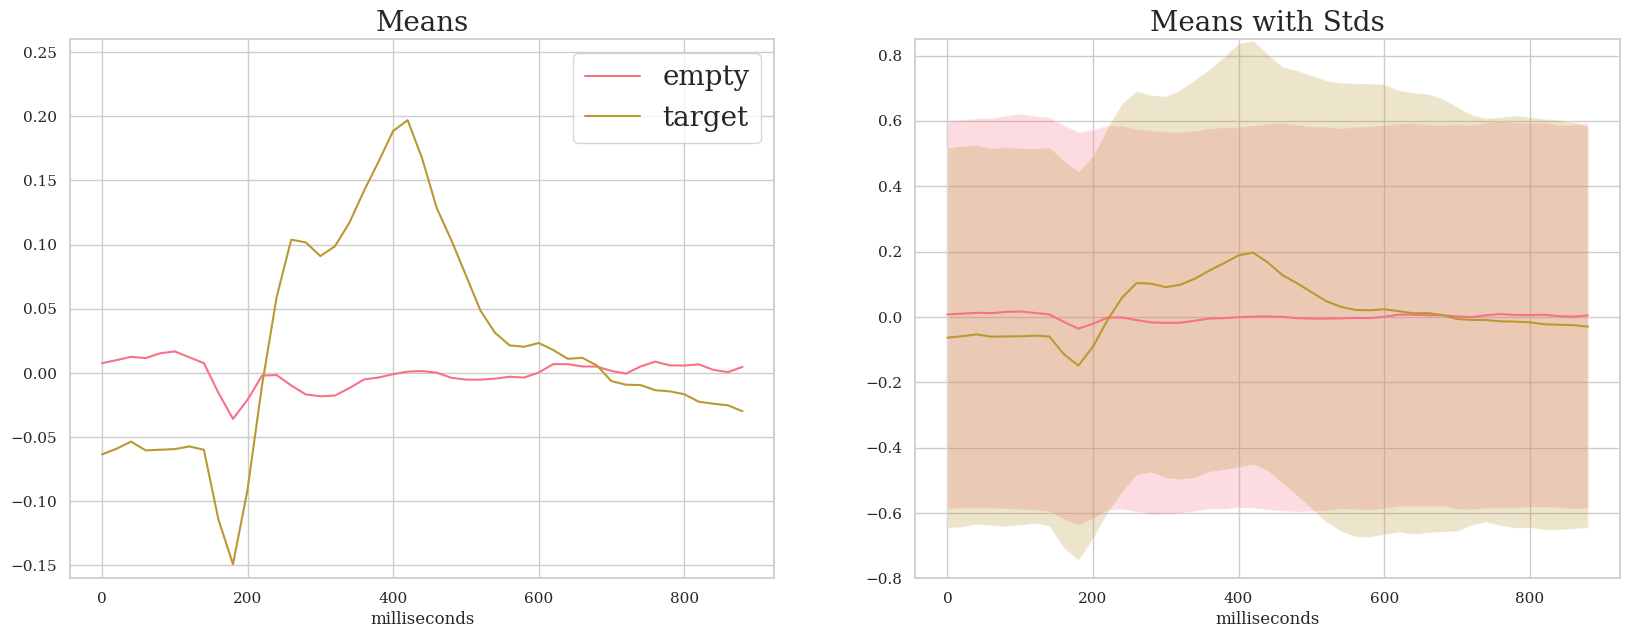

In [17]:
plot_by_labels(all_epochs, all_labels)

<ipython-input-16-3d474bf067c9>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(np.arange(-200, 1000, 200))


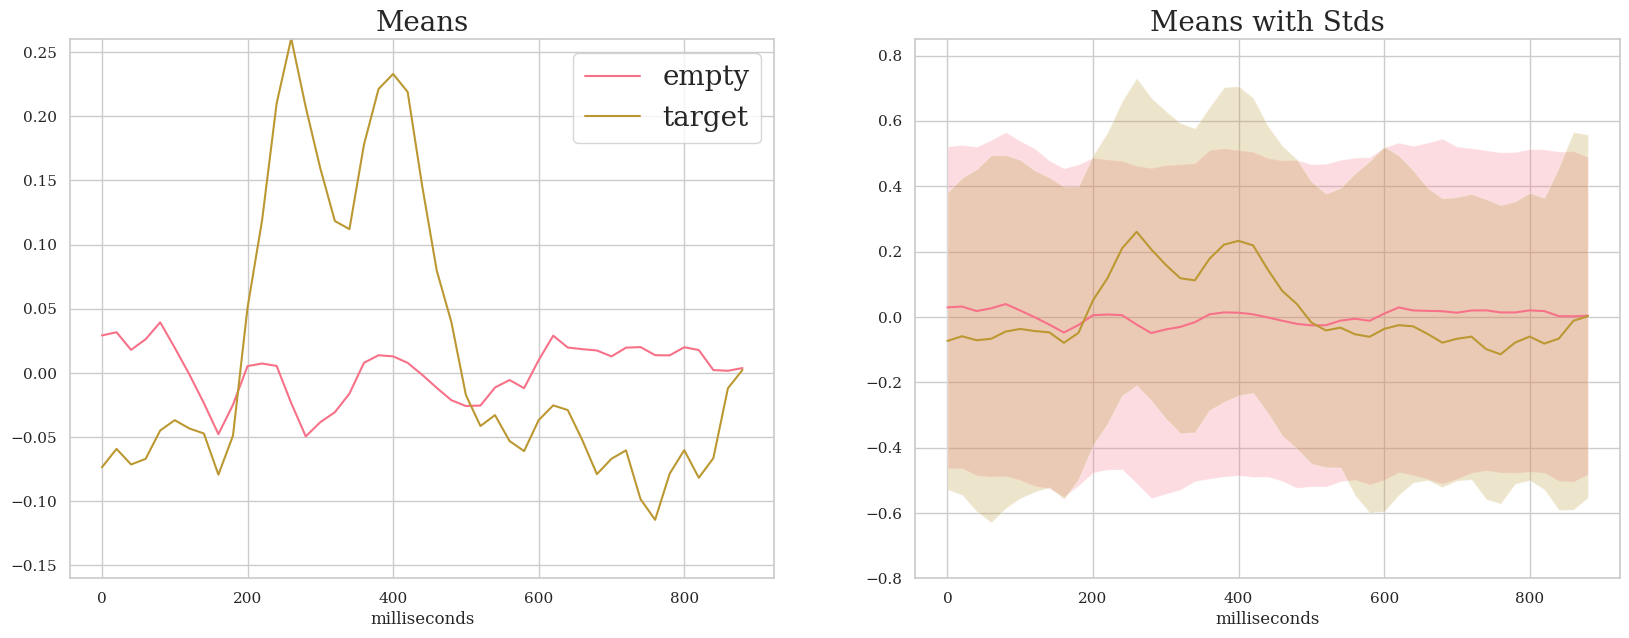

In [18]:
plot_by_labels(dataset[6][0], dataset[6][1])

In [19]:
len(dataset)

24

In [20]:
len(dataset[0])

2

In [21]:
type(dataset[0])

tuple

In [22]:
from tqdm import tqdm
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class SVM:
    def __init__(self, kernel='linear', C=10, max_iter=100, degree=3, gamma=1):
        self.kernel = {'poly':lambda x,y: np.dot(x, y.T)**degree,
                       'rbf':lambda x,y:np.exp(-gamma*np.sum((y-x[:,np.newaxis])**2,axis=-1)),
                       'linear':lambda x,y: np.dot(x, y.T)}[kernel]
        self.C = C
        self.max_iter = max_iter

    def restrict_to_square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y * 2 - 1 # из (0, 1) в (-1, 1)
        self.lambdas = np.zeros_like(self.y, dtype=float) #инициализируем лямбды нулями

        # матрица Грама, которая используется для расчёта схожести между всеми объектами
        self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y # K(i, j) = yi * yj * kernel(xi, xj)


        # последовательная минимальная оптимизация (SMO)
        # попарно обновляет значения множителей Лагранжа для двух случайно выбранных объектов на каждой итерации
        for _ in tqdm(range(self.max_iter)):
            for idxM in range(len(self.lambdas)): # выбираем индекс лямбды M
                idxL = np.random.randint(0, len(self.lambdas)) # случайно выбираем индекс лямбды L

                # матрица Гессе
                # используется для определения изменений в значениях лямбд для двух выбранных объектов
                Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]

                # текущее значение лямбд
                v0 = self.lambdas[[idxM, idxL]]

                # ошибка k = 1 - sum(lambdas * K(idxM, idxL))
                k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)

                # вектор обновлений, определённый метками классов для этих объектов
                u = np.array([-self.y[idxL], self.y[idxM]])

                # оптимальный шаг для обновления множителей Лагранжа
                t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)

                # Используя метод restrict_to_square, обновляются лямбды так, чтобы они оставались в пределах [0,C]
                self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)

        # Индексы объектов, для которых λ>1E−15, считаются опорными векторами, потому что именно эти объекты влияют на окончательную разделяющую гиперплоскость
        idx, = np.nonzero(self.lambdas > 1E-15)

        # Смещение b вычисляется на основе значений ядра для опорных векторов. Это смещение позволяет полностью определить разделяющую гиперплоскость
        self.b = np.sum((1.0-np.sum(self.K[idx]*self.lambdas, axis=1))*self.y[idx])/len(idx)
        return self

    def predict(self, X):
        return (self.predict_proba(X)>0.5).astype(int)
    def predict_proba(self, X):
        return sigmoid(np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b)

1. Инициализация: Создаётся матрица ядра для всех объектов и инициализируются множители Лагранжа.
2. Обучение: Метод SMO (последовательное минимальное оптимизирование) итеративно обновляет множители Лагранжа для случайно выбранных пар объектов, корректируя их для достижения оптимального разделения классов.
3. Определение опорных векторов: После обучения определяются опорные векторы (объекты, с ненулевыми значениями λ).
4. Предсказание: Для новых объектов вычисляется их позиция относительно разделяющей гиперплоскости, и на основе этого делается предсказание их классов.

In [24]:
import copy

In [25]:
dataset1 = copy.copy(dataset)

In [27]:
dataset2 = [(i[0].reshape(i[0].shape[0],16*45),i[1]) for i in dataset1]

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_data = dataset2[0][0]
y_data = dataset2[0][1]
x_train,x_test,y_train,y_test = train_test_split(X_data,y_data,test_size=0.2,random_state=42,stratify=y_data)

In [37]:
clf_test = SVM().fit(x_train,y_train)

y_pred = clf_test.predict(x_test)

100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


In [38]:
y_pred[0],y_pred[1],y_pred[2],y_pred[3]

(0, 1, 0, 0)

In [39]:
y_test[0],y_test[1],y_test[2],y_test[3]

(0, 1, 0, 0)

In [40]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print(f'accuracy={accuracy_score(y_test,y_pred)}')
print(f'f1_score={f1_score(y_test,y_pred)}')

accuracy=0.9580152671755725
f1_score=0.8817204301075269


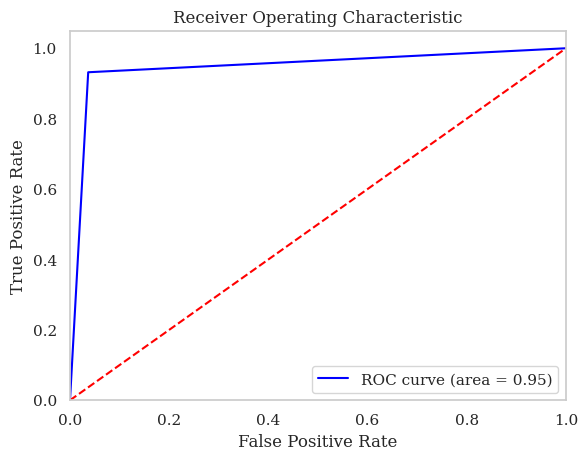

In [41]:
# Вычисляем значения для ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # fpr - уровень ложных срабатываний, tpr - уровень истинных срабатываний
roc_auc = auc(fpr, tpr)  # Площадь под кривой ROC

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия диагонали
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [43]:
clf_test = SVM(max_iter=10).fit(x_train,y_train)

y_pred = clf_test.predict(x_test)

100%|██████████| 10/10 [00:00<00:00, 11.11it/s]


In [44]:
print(f'accuracy={accuracy_score(y_test,y_pred)}')
print(f'f1_score={f1_score(y_test,y_pred)}')

accuracy=0.9351145038167938
f1_score=0.8089887640449438


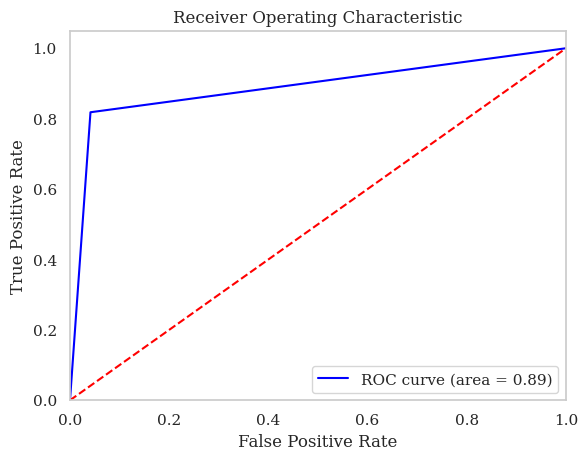

In [45]:
# Вычисляем значения для ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # fpr - уровень ложных срабатываний, tpr - уровень истинных срабатываний
roc_auc = auc(fpr, tpr)  # Площадь под кривой ROC

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия диагонали
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [46]:
clf_test = SVM(max_iter=5).fit(x_train,y_train)

y_pred = clf_test.predict(x_test)

100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


In [47]:
print(f'accuracy={accuracy_score(y_test,y_pred)}')
print(f'f1_score={f1_score(y_test,y_pred)}')

accuracy=0.9389312977099237
f1_score=0.8222222222222222


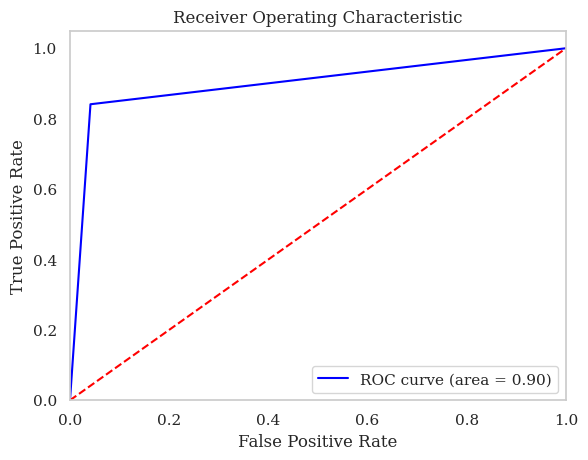

In [48]:
# Вычисляем значения для ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # fpr - уровень ложных срабатываний, tpr - уровень истинных срабатываний
roc_auc = auc(fpr, tpr)  # Площадь под кривой ROC

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия диагонали
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()